In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone

import mne

In [2]:
sns.set()

In [3]:
metadata = pd.read_csv("../data/01_EEG_Setup_Data_29-04/all_apps_wide-2024-04-29.csv")

In [4]:
NUMBER_OF_TRACKS = 50

In [5]:
rest_actions = ["Intro.1.player.rest_actions_eo", "Intro.1.player.rest_actions_ec"]
preferences = [f"Music_Discovery.{i}.player.preference" for i in range(1, NUMBER_OF_TRACKS)]

In [6]:
relevant_meta = [
    "participant.code"
] + rest_actions \
  + [f"Music_Discovery.{i}.player.time_start" for i in range(1, NUMBER_OF_TRACKS)] \
  + preferences
# not implemented yet
#  + [f"Music_Discovery.{i}.player.arousal" for i in range(1, NUMBER_OF_TRACKS)] \
#  + [f"Music_Discovery.{i}.player.valence" for i in range(1, NUMBER_OF_TRACKS)]

In [7]:
metadata[relevant_meta]

,participant.code,Intro.1.player.rest_actions_eo,Intro.1.player.rest_actions_ec,Music_Discovery.1.player.time_start,Music_Discovery.2.player.time_start,Music_Discovery.3.player.time_start,Music_Discovery.4.player.time_start,Music_Discovery.5.player.time_start,Music_Discovery.6.player.time_start,Music_Discovery.7.player.time_start,...,Music_Discovery.40.player.preference,Music_Discovery.41.player.preference,Music_Discovery.42.player.preference,Music_Discovery.43.player.preference,Music_Discovery.44.player.preference,Music_Discovery.45.player.preference,Music_Discovery.46.player.preference,Music_Discovery.47.player.preference,Music_Discovery.48.player.preference,Music_Discovery.49.player.preference
0,8i8h7tcz,;onLoad;Mon Apr 29 2024 16:30:32 GMT+0200 (Mit...,;onLoad;Mon Apr 29 2024 16:32:07 GMT+0200 (Mit...,1.714401e+12,1.714401e+12,1.714401e+12,1.714401e+12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ocwkjaf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
metadata["Music_Discovery.1.player.preference"]

0    5.0
1    NaN
Name: Music_Discovery.1.player.preference, dtype: float64

<Axes: ylabel='Frequency'>

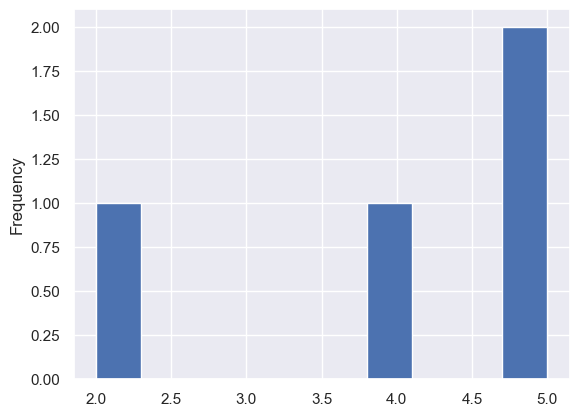

In [9]:
metadata.iloc[0][preferences].plot.hist()

In [10]:
def parse_calibration_timestamps(raw_timestamps: str) -> pd.Series:
    elems = raw_timestamps.split(";")[1:]
    if len(elems) % 3 != 0:
        raise Exception("number of elems in timestamp does not match expected format: name, time, timestamp")
    times = []
    for name, time, timestamp in zip(*(iter(elems), ) * 3):
        times.append((name, timestamp))
    s = pd.DataFrame.from_records(times, columns=["task", "timestamp"]).set_index("task")
    s = s.assign(timestamp=pd.to_datetime(pd.to_numeric(s.timestamp), unit="ms", origin="unix"))
    return s
    

In [11]:
calibration_times = pd.DataFrame()
for n, t in metadata.iloc[0][rest_actions].items():
    df = parse_calibration_timestamps(t)
    df["calib"] = n
    calibration_times = pd.concat([calibration_times, df])

In [12]:
calibration_times

,timestamp,calib
task,,
onLoad,2024-04-29 14:30:32.106,Intro.1.player.rest_actions_eo
taskStart,2024-04-29 14:30:33.614,Intro.1.player.rest_actions_eo
timeOut,2024-04-29 14:32:03.622,Intro.1.player.rest_actions_eo
onNextClick,2024-04-29 14:32:07.630,Intro.1.player.rest_actions_eo
onLoad,2024-04-29 14:32:07.792,Intro.1.player.rest_actions_ec
taskStart,2024-04-29 14:32:11.654,Intro.1.player.rest_actions_ec
timeOut,2024-04-29 14:33:41.669,Intro.1.player.rest_actions_ec
onNextClick,2024-04-29 14:33:45.566,Intro.1.player.rest_actions_ec


In [13]:
eeg = pd.read_csv("../data/01_EEG_Setup_Data_29-04/UnicornRecorder_20240429_163116.csv")

In [14]:
def load_eeg(filename: str, sample_rate_hz = 256) -> pd.DataFrame:
    file = os.path.basename(filename).split(".")[0]
    time = "".join(file.split("_")[1:])
    recording_start = pd.to_datetime(time, format="%Y%m%d%H%M%S")
    recording_start = recording_start.tz_localize('Europe/Berlin')
    recording_start = recording_start.tz_convert('UTC')
    recording_start = recording_start.tz_localize(None)

    sample_rate_ms = 1000 / sample_rate_hz
    
    df = pd.read_csv(filename)
    df["timestamp"] = pd.date_range(start=recording_start, periods=df.shape[0], freq=f"{sample_rate_ms}ms")
    return df.set_index("timestamp")

In [15]:
eeg = load_eeg("../data/01_EEG_Setup_Data_29-04/UnicornRecorder_20240429_163116.csv")

In [82]:
ch_names = [c for c in eeg.columns if "EEG" in c]
channel_names = ['F3', 'Fz', 'F4', 'T3', 'C3', 'C4', 'T4', 'Pz']

In [83]:
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types="eeg")

In [84]:
raw = mne.io.RawArray(eeg[ch_names].T, info)

Creating RawArray with float64 data, n_channels=8, n_times=133096
    Range : 0 ... 133095 =      0.000 ...   519.902 secs
Ready.


In [85]:
raw.set_montage('standard_1020')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


In [86]:
raw.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Users/gabriel/Library/Caches/pypoetry/virtualenvs/eeg-music-dCP-UTgu-py3.11/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


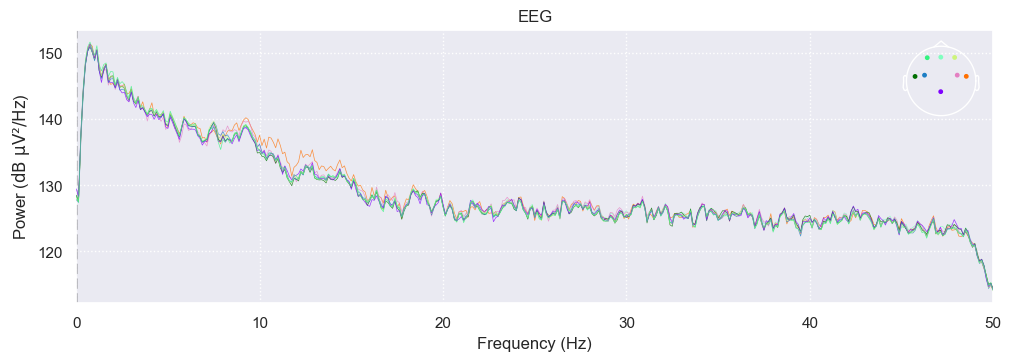

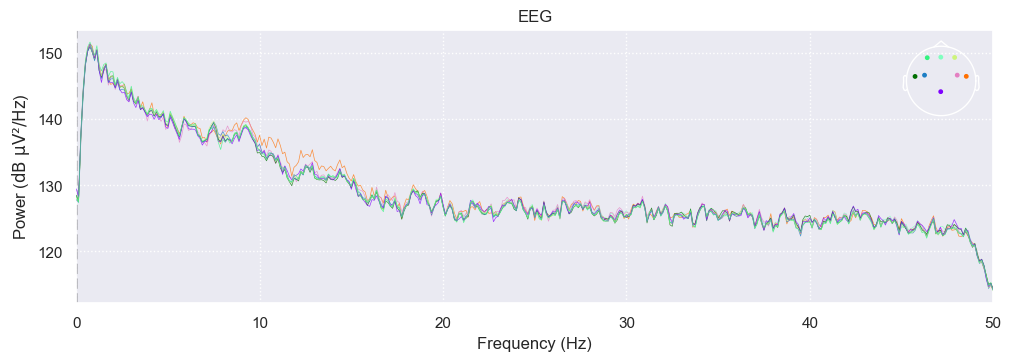

In [87]:
raw.compute_psd(fmax=50).plot(exclude="bads", amplitude=False)


In [88]:
eeg

,EEG 1,EEG 2,EEG 3,EEG 4,EEG 5,EEG 6,EEG 7,EEG 8,Accelerometer X,Accelerometer Y,Accelerometer Z,Gyroscope X,Gyroscope Y,Gyroscope Z,Battery Level,Counter,Validation Indicator
timestamp,,,,,,,,,,,,,,,,,
2024-04-29 14:31:16.000000000,-8.990,-4.092,-3.730,-4.836,0.319,3.418,7.284,1.022,-0.044,0.934,-0.360,0.580,0.458,0.336,80.0,741841.0,1.0
2024-04-29 14:31:16.003906250,-10.831,-6.544,-6.330,-5.083,-4.089,-3.187,1.484,-4.233,-0.044,0.934,-0.361,0.702,0.336,0.336,80.0,741842.0,1.0
2024-04-29 14:31:16.007812500,-9.418,-4.085,-6.783,-4.327,-6.062,-6.995,-2.627,-7.230,-0.043,0.935,-0.358,0.824,0.366,0.366,80.0,741843.0,1.0
2024-04-29 14:31:16.011718750,-8.657,-2.346,-7.242,-4.636,-7.570,-8.518,-5.956,-9.427,-0.043,0.937,-0.360,0.824,0.305,0.458,80.0,741844.0,1.0
2024-04-29 14:31:16.015625000,-8.311,-2.644,-6.580,-3.889,-7.421,-7.283,-7.056,-9.489,-0.044,0.937,-0.361,0.854,0.397,0.458,80.0,741845.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 14:39:55.886718750,16.561,15.019,13.076,11.198,10.158,13.102,-0.964,1.290,0.042,0.913,-0.451,17.487,-7.904,7.263,80.0,874932.0,1.0
2024-04-29 14:39:55.890625000,28.615,26.682,25.290,22.663,20.869,25.651,10.504,14.553,0.041,0.907,-0.455,16.937,-7.965,7.263,80.0,874933.0,1.0
2024-04-29 14:39:55.894531250,29.004,25.317,26.519,22.569,22.488,28.630,13.788,18.018,0.041,0.905,-0.457,16.510,-8.057,7.416,80.0,874934.0,1.0


In [23]:
c_times = calibration_times.reset_index().pivot(index="calib", columns="task", values="timestamp")

In [24]:
display(c_times)

task,onLoad,onNextClick,taskStart,timeOut
calib,,,,
Intro.1.player.rest_actions_ec,2024-04-29 14:32:07.792,2024-04-29 14:33:45.566,2024-04-29 14:32:11.654,2024-04-29 14:33:41.669
Intro.1.player.rest_actions_eo,2024-04-29 14:30:32.106,2024-04-29 14:32:07.630,2024-04-29 14:30:33.614,2024-04-29 14:32:03.622


In [29]:
(_, start_ec), (_, end_ec) = c_times.loc["Intro.1.player.rest_actions_ec"][["taskStart", "timeOut"]].items()

In [31]:
(_, start_eo), (_, end_eo) = c_times.loc["Intro.1.player.rest_actions_eo"][["taskStart", "timeOut"]].items()

In [32]:
eyes_closed = eeg[start_ec:end_ec]
eyes_open = eeg[start_eo:end_eo]

In [41]:
eyes_closed[ch_names].describe()

,EEG 1,EEG 2,EEG 3,EEG 4,EEG 5,EEG 6,EEG 7,EEG 8
count,23044.000000,23044.000000,23044.000000,23044.000000,23044.000000,23044.000000,23044.000000,23044.000000
mean,0.060931,0.020267,0.031221,0.028282,0.005408,-0.002498,-0.003960,-0.019369
std,16.273028,15.245672,16.521207,13.153225,15.806201,15.056537,12.888348,13.401579
min,-113.190000,-86.403000,-90.724000,-61.823000,-76.100000,-69.097000,-53.441000,-60.510000
25%,-9.376250,-9.277500,-9.908500,-8.076500,-9.848250,-9.390000,-8.504500,-8.536250
50%,0.205500,0.171500,0.204500,0.133500,0.155500,0.058500,0.088500,0.434000
75%,9.474000,9.475750,10.226500,8.487500,10.292750,9.730250,8.572250,8.834000
max,138.286000,89.859000,89.880000,61.877000,57.946000,59.103000,47.505000,50.203000


In [42]:
eyes_open[ch_names].describe()

,EEG 1,EEG 2,EEG 3,EEG 4,EEG 5,EEG 6,EEG 7,EEG 8
count,12192.000000,12192.000000,12192.000000,12192.000000,12192.000000,12192.000000,12192.000000,12192.000000
mean,-0.064361,-0.043399,-0.049118,-0.067969,-0.060025,-0.047958,-0.056786,-0.065637
std,22.621486,19.456180,19.458287,17.956520,18.416445,16.263504,15.268464,14.601605
min,-111.148000,-117.572000,-114.707000,-110.996000,-114.844000,-86.434000,-92.037000,-91.141000
25%,-10.064500,-7.877500,-8.371750,-6.862250,-7.560500,-7.544750,-6.954000,-6.594000
50%,0.310000,0.003000,-0.120000,-0.146500,0.003500,0.098000,0.120000,0.091000
75%,9.268750,7.776000,8.058750,6.822500,7.556750,7.282250,7.073000,6.392000
max,259.594000,259.555000,266.958000,270.306000,266.380000,165.986000,148.419000,139.595000


In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [59]:
eyes_open["variant"] = "eyes_open"
eyes_closed["variant"] = "eyes_closed"

/var/folders/tg/0bn145lj4m79bpv0fbq1df_m0000gn/T/ipykernel_85711/4261353759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eyes_open["variant"] = "eyes_open"
/var/folders/tg/0bn145lj4m79bpv0fbq1df_m0000gn/T/ipykernel_85711/4261353759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eyes_closed["variant"] = "eyes_closed"


In [60]:
both = pd.concat([eyes_open, eyes_closed])

In [72]:
scaled = pd.DataFrame(scaler.fit_transform(both[ch_names]), columns=ch_names)
scaled["variant"] = both.reset_index().variant

In [73]:
scaled

,EEG 1,EEG 2,EEG 3,EEG 4,EEG 5,EEG 6,EEG 7,EEG 8,variant
0,-0.481317,-0.243152,-0.212216,-0.322281,0.020068,0.221916,0.531047,0.076465,eyes_open
1,-0.579691,-0.388916,-0.360006,-0.338758,-0.243018,-0.204643,0.109480,-0.303555,eyes_open
2,-0.504187,-0.242736,-0.385756,-0.288325,-0.360775,-0.450569,-0.189325,-0.520286,eyes_open
3,-0.463524,-0.139358,-0.411846,-0.308938,-0.450778,-0.548926,-0.431290,-0.679164,eyes_open
4,-0.445035,-0.157073,-0.374217,-0.259105,-0.441885,-0.469168,-0.511243,-0.683648,eyes_open
...,...,...,...,...,...,...,...,...,...
35231,0.204036,0.327895,0.221831,-0.061506,0.410161,0.674243,0.281523,-0.080822,eyes_closed
35232,0.199922,0.358629,0.219614,-0.090392,0.361996,0.651381,0.255720,-0.111990,eyes_closed
35233,0.375348,0.664068,0.514569,0.199802,0.605745,0.895498,0.625682,0.224858,eyes_closed
35234,0.492637,0.888896,0.793039,0.453972,0.875694,1.084205,1.067747,0.658103,eyes_closed


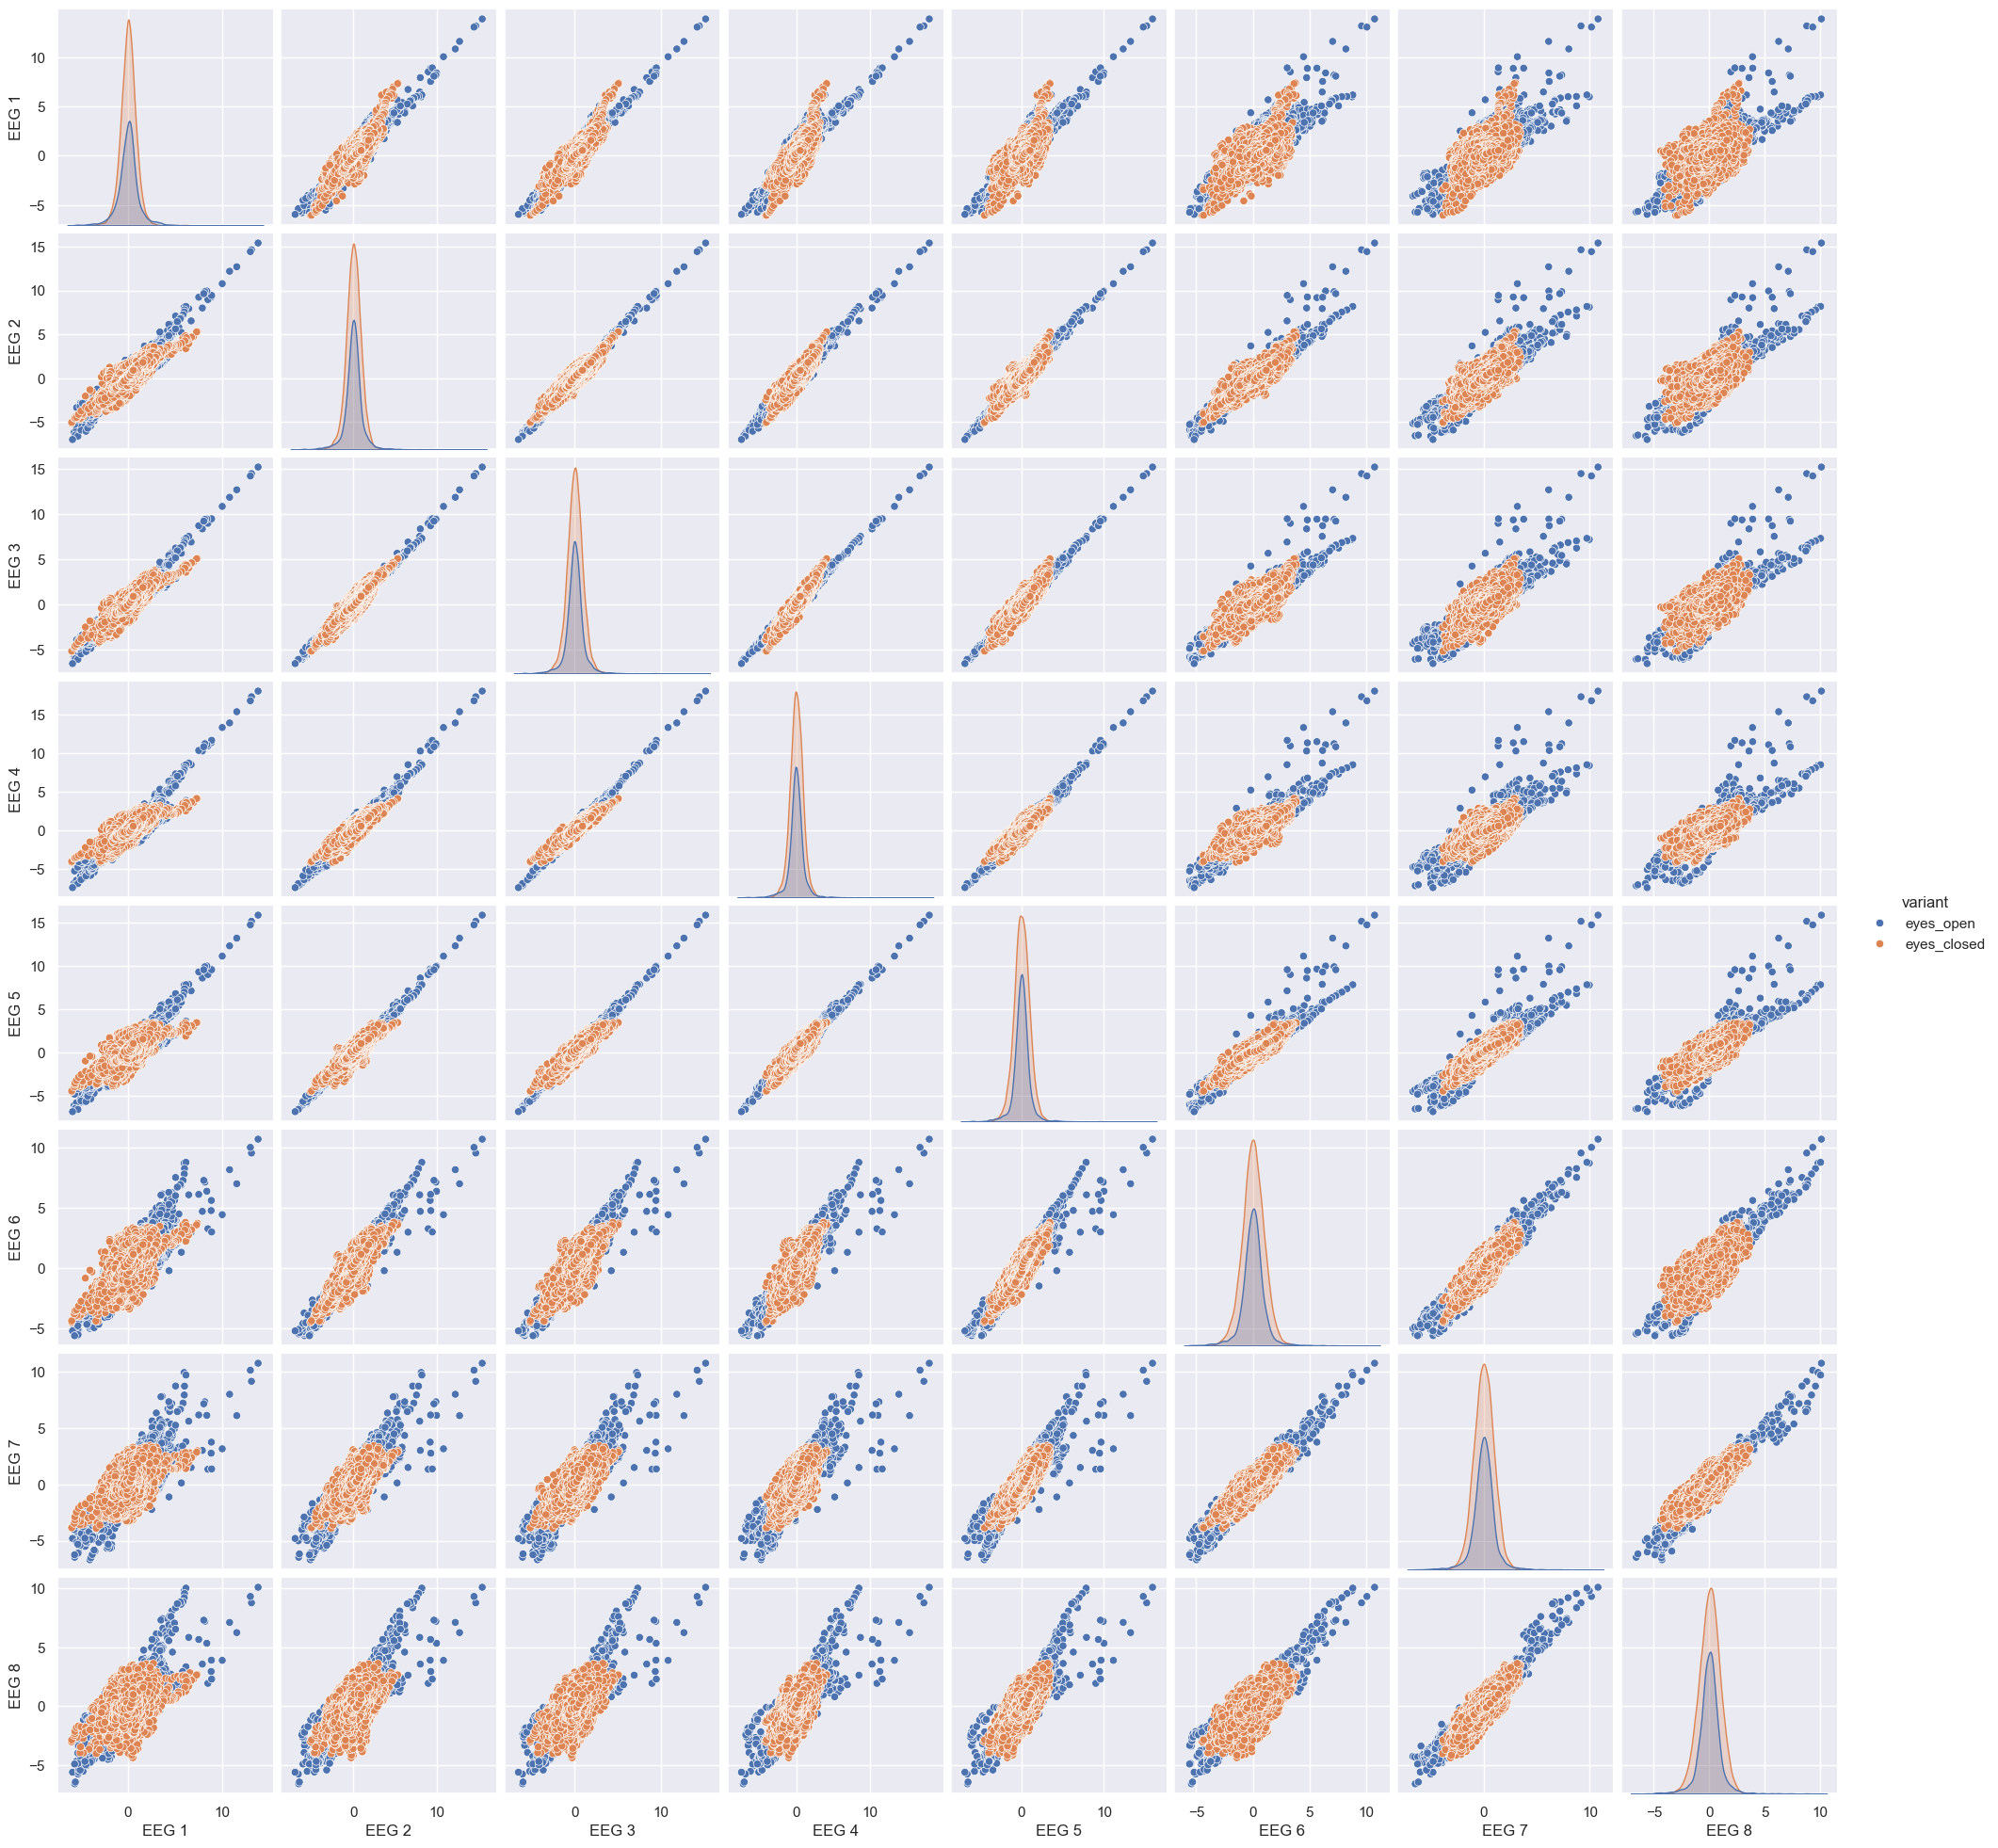

In [74]:
sns.pairplot(data=scaled, hue="variant")

In [75]:
from sklearn.manifold import TSNE

In [ ]:
df = scaled.copy()
X = df.drop(columns=['variant'])
y = df['variant']

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with t-SNE results and the variant column
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE 1', 'TSNE 2'])
tsne_df['variant'] = y

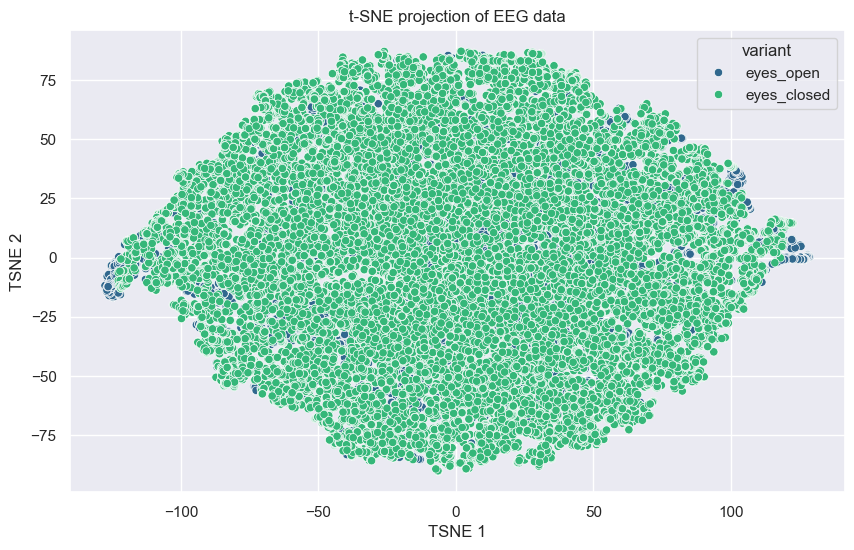

In [80]:
# Plotting the t-SNE results using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='variant', palette='viridis', data=tsne_df)
plt.title('t-SNE projection of EEG data')
plt.show()